# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» (название вымышленное) внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Задачи:**

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество с помощью метрики качества MAE и получить адекватный результат (в идеале около 7)

## Исследовательский анализ данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt# < Перенесите сюда исследовательский анализ данных >
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.shape

(7591, 2)

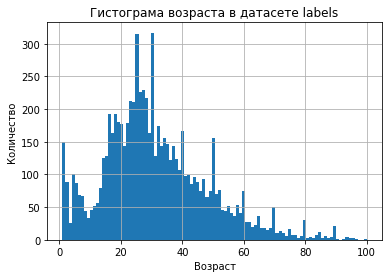

In [ ]:
labels.hist(bins=100)
plt.title('Гистограма возраста в датасете labels')
plt.xlabel('Возраст')
plt.ylabel('Количество');

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


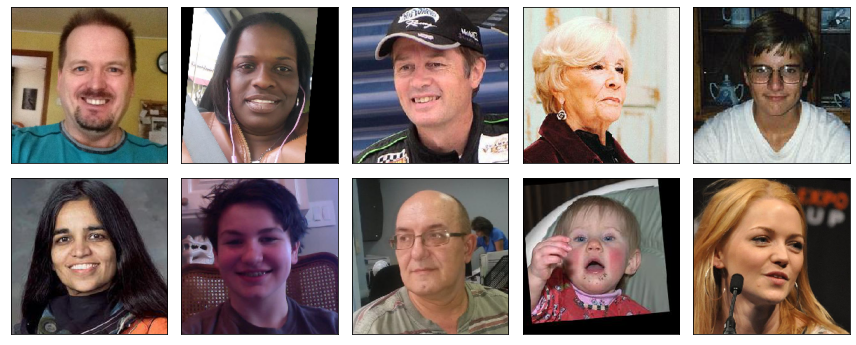

In [ ]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(12,12))
for i in range(10):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод:
1. Имеем датасет более 7500+ строк-фотографий
2. Возрасты представлены от 1 до 100 лет
3. Средний - 31 год, медианный 29
4. Есть чб фотографии, есть цветные, есть с закрытыми глазами, есть под странным наклоном, многообразие это конечно хорошо, но может сказаться на обучении в худшую сторону, все-таки определение возраста сложная штука, и данных 7,5к строк может быть недостаточно, тем более таких

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=32,
        class_mode='raw', subset='training',
        seed=42)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=32,
        class_mode='raw', subset='validation',
        seed=42)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', classes=100,
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model# < скопируйте код сюда >

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-04-28 17:23:22.530248: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-28 17:23:22.940895: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 66s - loss: 200.3805 - mae: 10.4972 - val_loss: 624.6773 - val_mae: 19.9066
Epoch 2/10
178/178 - 52s - loss: 102.1628 - mae: 7.6927 - val_loss: 300.3256 - val_mae: 12.9022
Epoch 3/10
178/178 - 46s - loss: 67.6670 - mae: 6.2836 - val_loss: 445.6070 - val_mae: 15.8247
Epoch 4/10
178/178 - 41s - loss: 45.9154 - mae: 5.2228 - val_loss: 465.8226 - val_mae: 16.2153
Epoch 5/10
178/178 - 50s - loss: 33.0658 - mae: 4.4145 - val_loss: 143.5565 - val_mae: 9.5070
Epoch 6/10
178/178 - 51s - loss: 24.5769 - mae: 3.8319 - val_loss: 96.2782 - val_mae: 7.6083
Epoch 7/10
178/178 - 47s - loss: 17.1800 - mae: 3.2115 - val_loss: 90.4234 - val_mae: 7.1747
Epoch 8/10
178/178 - 44s - loss: 14.9692 - mae: 2.9542 - val_loss: 90.2105 - val_mae: 7.3707
Epoch 9/10
178/178 - 50s - loss: 12.9614 - mae: 2.7774 - val_loss: 78.2087 - val_mae: 6.7068
Epoch 10/10
178/178 - 50s - loss: 11.9823 - mae: 2.6709 - val_loss: 85.0111 - val_mae: 7.2741
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 85.0111 - mae: 7.2741
Test MAE: 7.2741# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

В данной работе исследовались модели на основе свёрточной сети ResNet50. Полученная модель дала на метрике качества MAE результат 7.2, что в целом можно отнести к неплохому результату.
Полученный результат вряд ли способен удовлетворить поставленную изначально задачу, а именно:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Все таки погрешность достаточно большая:C